In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms

import train_utils.transforms
from models.hrnet import HighResolutionNet
import torchvision.transforms as transforms

In [2]:
def inference():
    img_path = "test.jpg"
    # Ls / + Lu / +Lf
    weights_path = "saved_weights/ls_lu_lf.pth"
    model = HighResolutionNet(num_joints=21)
    weights = torch.load(weights_path)
    # model.load_state_dict(weights['model'])
    model.load_state_dict(weights)
    model.eval()
    model.to("cuda:0")

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    desired_size = (256, 256)
    resized_image = cv2.resize(image, desired_size)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    normalized_image = transform(resized_image)

    with torch.no_grad():
        normalized_image = normalized_image.unsqueeze(0).to("cuda:0")
        outputs = model(normalized_image)
        coords,confidence = train_utils.transforms.get_max_preds(outputs)
        confidence = np.array(confidence.squeeze(0).squeeze(-1).cpu())

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img_tensor = (normalized_image.squeeze(0).cpu() * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1))
        img_tensor = img_tensor.clamp(0,1)
        to_pil = torchvision.transforms.ToPILImage()
        img_np = to_pil(img_tensor)
        source_size = torch.tensor([256, 256])
        target_size = torch.tensor([64, 64])
        scaled_keypoints_tensor = coords.cpu().squeeze(0) * (source_size.float() / target_size.float())
        scaled_keypoints = scaled_keypoints_tensor.int().tolist()
        for i,point in enumerate(scaled_keypoints):
            x, y = point
            if confidence[i] > 0.4:
                plt.scatter(x, y, s=100,color='white',edgecolors='black')

        plt.imshow(img_np)
        plt.axis('off')
        plt.show()

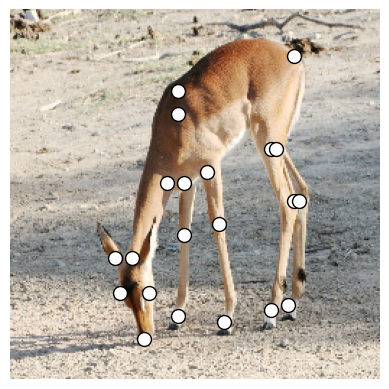

In [3]:
if __name__ == '__main__':
    inference()